# Gradient Descent with diamonds.csv


# Diamonds dataset

This is just an example of running gradient descent with diamonds data set. This dataset it taken from Kaggle: https://www.kaggle.com/shivam2503/diamonds.

First step is to just observe the data and try to understand the meaning of different columns.

In [0]:
import numpy as np
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt


df = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv')
print(df.head())

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


## Observation

We can see that the column we want to predict using gradient descent is the price of diamond.

We see that there are three columns that are categorical data: cut, clarity and color. We should convert this into numbers to make it possible to analyze. Based on Kaggle information we can assign some numerical values or weights to each category.

Once these columns have numerical values, we do the correlation to observe which columns are more correlated to others.

In [0]:
# se convierten las columnas categóricas en columnas numéricas
cut = {'Fair':1,'Good':2,'Very Good':3,'Premium':4,'Ideal':5}
clarity = {'I1':1, 'SI2':2,'SI1':3,'VS2':4,'VS1':5,'VVS2':6,'VVS1':7,'IF':8}
color = {'J':1,'I':2,'H':3,'G':4,'F':5,'E':6,'D':7, }

df['cut'].replace(cut, inplace=True)
df['clarity'].replace(clarity, inplace=True)
df['color'].replace(color, inplace=True)

df.corr()

,carat,cut,color,clarity,depth,table,price,x,y,z
carat,1.000000,-0.134967,-0.291437,-0.352841,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
cut,-0.134967,1.000000,0.020519,0.189175,-0.218055,-0.433405,-0.053491,-0.125565,-0.121462,-0.149323
color,-0.291437,0.020519,1.000000,-0.025631,-0.047279,-0.026465,-0.172511,-0.270287,-0.263584,-0.268227
clarity,-0.352841,0.189175,-0.025631,1.000000,-0.067384,-0.160327,-0.146800,-0.371999,-0.358420,-0.366952
depth,0.028224,-0.218055,-0.047279,-0.067384,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.433405,-0.026465,-0.160327,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.053491,-0.172511,-0.146800,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.125565,-0.270287,-0.371999,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.121462,-0.263584,-0.358420,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,-0.149323,-0.268227,-0.366952,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


## Analysis

Based on the correlation we can observe that the value that is more related to the price is the carat. But also other columns related to the diamond size have high correlation. So, let's used all values in this model.

Let's put this problem in the following way: $A\vec{x}=b$. Where $A$ is the whole matrix, $b$ is the price, and $\vec{x}$ is the vector with the weights we want to find the minimum using gradient descent.

Also, let's use half of the matrix to do the training and the other half to test the model.

In [0]:
train_size = int((df.shape[0])/2)
matrix = df.as_matrix()

A_train = matrix[0:train_size,[0,1,2,3,4,5,7,8,9]]
b_train = matrix[0:train_size,6]

A_test = matrix[train_size:-1,[0,1,2,3,4,5,7,8,9]]
b_test = matrix[train_size:-1,6]

# se inicializan m y n, como las filas y las columnas de A
m, n = np.shape(A_train)

# se inicializa como puros unos
x = np.ones(n)

# Model

Before implementing the model using python, let's normalize the data $A$ using the mean normalization.

In [0]:
# mean normalization
def normalize(matrix_to_normalize):
  normalized = np.array(matrix_to_normalize, dtype=np.float)
  for i in range(n):
    col = np.array(normalized[:,i])
    normalized[:,i] = (col - np.amin(col)) / \
                       (np.amax(col) - np.amin(col))
    
  return normalized

A_train = normalize(A_train)

## Gradient descent implementation

It's known gradient descent is an iterative function to find the minimun, where the next value is determined by the current value plus a coeficient alpha $\alpha$ of the derivative of the funtion, the following way:

\begin{equation}
x\left(t+1\right)=x\left(t\right)+\alpha f'\left(x\left(t\right)\right)
\end{equation}

Where function $f$ is called cost function. 

If we use the hypothesis of a linear regression fucntion, we have the folowing hypothesis *h*: 

\begin{equation}
h_{a} = a_{1}x_{1} +a_{2}x_{2} + .. + a_{n}x_{n}
\end{equation}

Note that ***h***  can be represented as the product of a matrix  $A$ and and the weights vector $x$ as follows:  $np.dot(A, x)$ using numpy.

Then, if we iterate $n$ times, the gradient descent function hopefully will converge to the minimum.

Let's create a based method for gradient descent with the following parameters:

*   $A$: The matrix with all train data
*   $b$: The vector with the prices
*   $x$: The weights we want to predict
*   $alpha$: The learning rate
*   $m$: The number of rows matrix $A$ has
*   $maxiteration$: The number of iterations we want to put as a limit
*   $cost func$ The cost function
*   $gradient func$ The gradient function
*   $alfa func$ The function to find $\alpha$ because we want to change alpha as the gradient descent is running.



In [0]:
def populate_error_cost_hist(error_hist, cost_hist, i, cost, error, first_cost, first_error):    
  error_percent = (error/first_error) * 100;
  cost_percent = (cost/first_cost) * 100;

  error_hist.append(error_percent)
  cost_hist.append(cost_percent)  
  

def gradient_descent(A, b, x, alpha, m, max_iteration, cost_fuc, gradient_func, alfa_func, debug_info = False):
    ATrans = A.transpose()
    error_hist = []
    cost_hist = []
    for i in range(0, max_iteration):
        loss, cost = cost_fuc(A, b, x, m)
        gradient = gradient_func(ATrans, loss, m)
        x = x - alpha * gradient
        
        alpha = alfa_func(alpha, m, i)
        
        prediction = np.dot(A_train, x)
        l2norm_error = np.sqrt(np.sum((prediction - b_train)**2))
        
        if (i % 1000) == 0 and debug_info:
          print("Iteration %d | Cost: %f | Error: %f | Alpha: %f" % (i, cost, l2norm_error, alpha))
        
        if(i == 0):
          first_error = l2norm_error
          first_cost = cost
          
        populate_error_cost_hist(error_hist, cost_hist, i, cost, l2norm_error, first_cost, first_error)
    return x, error_hist, cost_hist

## Using norm L2 as a cost function

Let's try using norm L2 as a cost function :

\begin{equation}
f(x)=\sqrt{\sum_{i=1}^{m}\left(h\left(a_{i}\right) - b\right)^2}
\end{equation}

If we derivate this cost fuction we have the following result:

\begin{equation}
f'(x)=\frac{\sum_{i=1}^{m} (h\left(a_{i}\right) - b)a_{i}}{\sqrt{\sum_{i=1}^{m}\left(h\left(a_{i}\right) - b\right)^2}}
\end{equation}



In [0]:
def cost_l2(A, b, x, m):
  loss = np.dot(A, x) - b
  cost = np.sqrt(np.sum((loss) ** 2))
  return loss, cost

def gradient_l2(ATrans, loss, m):
  return np.dot(ATrans, loss) / np.sqrt(np.sum((loss) ** 2))

## Using mean square error function

Let's try another cost function, this one is known as mean square error function:

\begin{equation}
f(x)=\frac{1}{2m} \sum_{i=1}^{m}\left(h\left(a_{i}\right) - b\right)^2
\end{equation}

If we derivate this cost fuction we have the following result:

\begin{equation}
f'(x)=\frac{1}{m} \sum_{i=1}^{m}\left(h\left(a_{i}\right) - b\right)a
\end{equation}


In [0]:
def cost_mean_square_error(A, b, x, m):
  loss = np.dot(A, x) - b
  cost = np.sum((loss) ** 2) / (2 * m)
  return loss, cost

def gradient_mean_square_error(ATrans, loss, m):
  return np.dot(ATrans, loss) / m

## Alpha reduction

There are several ways to reduce $\alpha$ as the model progresses. Here are two examples: 

In [0]:
def alpha_reduction(alpha, m, i):
  return alpha - (alpha/(np.e * m))

def alpha_slow_reduction(alpha, m, i):
  if (i % 100) == 0:
    alpha = alpha - (alpha/(np.e * m))
  return alpha


# Experiments

Let's try first with 10000 iterations and an alpha starting at 0.5 with all columns, using mean square error cost function.

Iteration 0 | Cost: 26239946.965241 | Error: 592884.500400 | Alpha: 0.499993
Iteration 1000 | Cost: 1032352.584703 | Error: 235963.315488 | Alpha: 0.493219
Iteration 2000 | Cost: 958856.391235 | Error: 227416.414802 | Alpha: 0.486537
Iteration 3000 | Cost: 925520.809352 | Error: 223430.787057 | Alpha: 0.479946
Iteration 4000 | Cost: 907812.064348 | Error: 221284.175050 | Alpha: 0.473444
Iteration 5000 | Cost: 898047.212042 | Error: 220091.524073 | Alpha: 0.467029
Iteration 6000 | Cost: 892583.872039 | Error: 219421.411495 | Alpha: 0.460702
Iteration 7000 | Cost: 889492.674899 | Error: 219041.344576 | Alpha: 0.454461
Iteration 8000 | Cost: 887722.893735 | Error: 218823.447664 | Alpha: 0.448304
Iteration 9000 | Cost: 886695.720196 | Error: 218696.879756 | Alpha: 0.442230
[-325202.92432231 -327438.06265672 -324872.52765623 ... -359176.90655288
 -373259.88610909 -373635.506887  ]


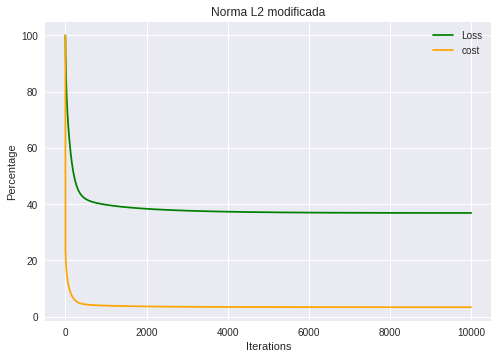

In [0]:
max_iterations= 10000
alpha = 0.5

x, error_hist, cost_hist = gradient_descent(A_train, b_train, x, alpha, m, max_iterations, 
                                            cost_mean_square_error, 
                                            gradient_mean_square_error, 
                                            alpha_reduction, True)

prediction = np.dot(A_test, x)
print(prediction)


axes = plt.subplots()[1]
axes.plot(error_hist, color='green', label='Loss')
axes.plot(cost_hist, color='orange', label='cost')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Percentage')
plt.title('Norma L2 modificada')
plt.show()


## Experiment removing non-related columns



Iteration 0 | Cost: 1187556.905883 | Error: 1153622.966552 | Alpha: 0.015000
Iteration 1000 | Cost: 490099.940035 | Error: 490081.724895 | Alpha: 0.014797
Iteration 2000 | Cost: 472493.042689 | Error: 472476.046551 | Alpha: 0.014596
Iteration 3000 | Cost: 456107.621084 | Error: 456091.847438 | Alpha: 0.014398
Iteration 4000 | Cost: 440942.585857 | Error: 440928.028838 | Alpha: 0.014203
Iteration 5000 | Cost: 426986.993527 | Error: 426973.636978 | Alpha: 0.014011
Iteration 6000 | Cost: 414219.319981 | Error: 414207.136961 | Alpha: 0.013821
Iteration 7000 | Cost: 402607.230125 | Error: 402596.182950 | Alpha: 0.013634
Iteration 8000 | Cost: 392107.911397 | Error: 392097.952267 | Alpha: 0.013449
Iteration 9000 | Cost: 382668.978133 | Error: 382660.050306 | Alpha: 0.013267
[ 8787.25955953 11942.5257073  11091.47918325 ...  4510.84920607
  4414.68016209  5229.26241276]


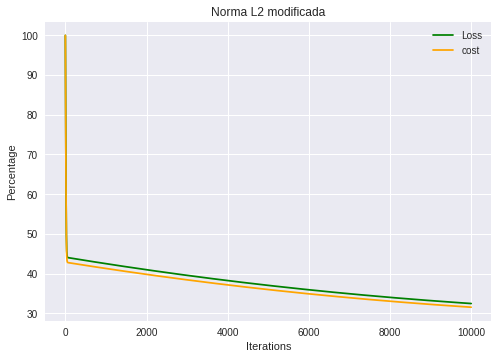

In [0]:
A_train = matrix[0:train_size,[0,7,8,9]]
b_train = matrix[0:train_size,6]

A_test = matrix[train_size:-1,[0,7,8,9]]
b_test = matrix[train_size:-1,6]

# se inicializan m y n, como las filas y las columnas de A
m, n = np.shape(A_train)

# se inicializa como puros unos
x = np.ones(n)

max_iterations= 10000
alpha = 0.015

x, error_hist, cost_hist = gradient_descent(A_train, b_train, x, alpha, m, max_iterations, 
                                            cost_l2, 
                                            gradient_l2, 
                                            alpha_reduction, True)

prediction = np.dot(A_test, x)
print(prediction)


axes = plt.subplots()[1]
axes.plot(error_hist, color='green', label='Loss')
axes.plot(cost_hist, color='orange', label='cost')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Percentage')
plt.title('Norma L2 modificada')
plt.show()

## Comparing our results against least square method

Let's select the best configuration and compare it with leas square method that we know it's an exact way to find a mininum for this example.

In [0]:
x, error_hist, cost_hist = gradient_descent(A_train, b_train, x, alpha, m, max_iterations, 
                                            cost_mean_square_error, 
                                            gradient_mean_square_error, 
                                            alpha_reduction, True)
prediction = np.dot(A_test, x)
prediction_error = np.sqrt(np.sum((prediction - b_test)**2))

lstsqr_x = np.linalg.lstsq(A_test, b_test)[0]
lstsqr_prediction = np.dot(A_test, lstsqr_x)
lstsqr_prediction_error = np.sqrt(np.sum((lstsqr_prediction - b_test)**2))

print("Our Model Prediction Error %f | Numpy Least Square Prediction Error: %f" % (prediction_error, lstsqr_prediction_error))

Iteration 0 | Cost: 2596366.485682 | Error: 374103.333534 | Alpha: 0.015000
Iteration 1000 | Cost: 1912283.719119 | Error: 321152.644035 | Alpha: 0.014797
Iteration 2000 | Cost: 1840640.651563 | Error: 315092.149707 | Alpha: 0.014596
Iteration 3000 | Cost: 1831920.537628 | Error: 314346.368088 | Alpha: 0.014398
Iteration 4000 | Cost: 1830527.872205 | Error: 314227.053561 | Alpha: 0.014203
Iteration 5000 | Cost: 1830170.054520 | Error: 314196.373628 | Alpha: 0.014011
Iteration 6000 | Cost: 1830014.175034 | Error: 314183.001438 | Alpha: 0.013821
Iteration 7000 | Cost: 1829921.964492 | Error: 314175.089374 | Alpha: 0.013634
Iteration 8000 | Cost: 1829860.842275 | Error: 314169.844387 | Alpha: 0.013449
Iteration 9000 | Cost: 1829818.756999 | Error: 314166.232858 | Alpha: 0.013267
Our Model Prediction Error 168506.339221 | Numpy Least Square Prediction Error: 159606.531461


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
